# Пример использования библиотеки BigARTM для тематического моделирования

**BigARTM 0.9.0**

Импортируем BigARTM:

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path="/Users/avvallack/Documents/coursera/C3/W4/school.txt", data_format="vowpal_wabbit", target_folder="school_batches", 
                                       batch_size=100)

В следующий раз данные можно считывать уже из батчей:

In [5]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем объект модели:

In [6]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1})
# число после названия модальностей - это их веса

In [9]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

Создаем словарь и инициализируем модель с его помощью

In [17]:
np.random.seed(1)
l_dictionary = artm.Dictionary('l_dictionary')
l_dictionary.gather(batch_vectorizer.data_path)
model_artm.initialize('l_dictionary')

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [19]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

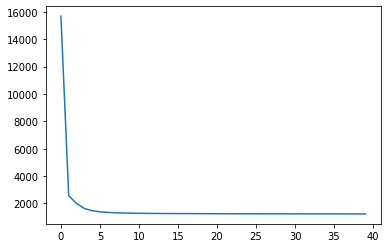

In [20]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [24]:
for topic_name in model_artm.topic_names:
    print (topic_name + ': ', end=" ")
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print (word, end=" ")
    print ('')

sbj0:  быть право который ребенок человек язык они семья это русский время для также свой что 
sbj1:  что свой который быть это человек этот его герой она они жизнь ребенок как такой 
sbj2:  предложение слово который что например это как быть или речь такой они если мочь этот 
sbj3:  который что ядро это этот энергия вода земля быть масса атом как температура такой океан 
sbj4:  поэт пушкин что стихотворение который свой это быть звук этот весь лирика год его произведение 
sbj5:  x быть a b число этот при функция уравнение что это для если сила ток 
sbj6:  который человек свой что жизнь его быть герой это как произведение литература этот для русский 
sbj7:  который человек общество развитие социальный государство как политический быть это себя культура жизнь такой отношение 
sbj8:  страна государство население который быть территория этот год являться город африка время что также хозяйство 
sbj9:  быть который год государство война становиться свой что весь первый военный как время пер

Давайте посмотрим также на разреженность матриц:

In [26]:
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.7677122950553894
0.0018907563062384725


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [40]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

AttributeError: Unable to replace existing regularizer.                                  If you really want to do it use overwrite=True argument

In [41]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Попробуем менять коэффициент регуляризации:

In [42]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [43]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [44]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ')
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:
        print(word)
    print('')

sbj0: 


KeyError: 'sbj0'

In [46]:
# еще раз посмотрим на разреженность
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

1.0
1.0


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [36]:
model_artm.save("my_model")

In [37]:
model_artm.load("my_model")

NameError: name 'transaction_typenames' is not defined

Можно попросить матрицы в чистом виде:

In [38]:
phi = model_artm.get_phi()

In [39]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
"(text, пластинка)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(text, фотопластинка)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(text, Добросклонова)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(text, лирикиОсобенно)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(text, вправе)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
"(text, кинетический)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(text, спроецировать)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(text, соотноситься)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(text, эпицентр)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Матрица вероятностей тем в документах.

In [ ]:
theta = model_artm.get_theta()
theta

Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [ ]:
theta_test = model_artm.transform(batch_vectorizer, num_document_passes=10)